In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
#from scipy.optimize import curve_fit

# module containing the main functions
import utils as ut

In [2]:
def stop_cond(_vars, pars):
    """
    Stop condition of having the positive growth rate theta times smaller 
    than gamma
    """
    Ts, P, Ss = _vars
    growth_rates = pars.betas * P * (1 - Ss)
    gr_small_than_th = np.sum(growth_rates / pars.gamma < theta)
    return gr_small_than_th >= pars.n

def sq_func(x, a, b, c):
    return a*x**2 + b*x + c

# Phase diagram varying $\tau_{crit}$ and $\alpha_0$ 

In [3]:
# Sampling taus from lognormal with default parameters
logmean, logstd, n_samples = -4, 2.5, 100

# Integration parameters
t_steps, dt, traj_steps = 500, 0.005, 30

# Stopping condition parameter
theta = 0.2  

## Which time to use for computing the diagram observables?

Condition: all the $T_i$ trajectories have a positive growth rate smaller than the constant death rate (memory phase when the expansion due to antigens is small):
$$
\beta_i P(t) (1 - S_i(t)) / \gamma < \theta 
$$
where $\theta$ is a threshold to be chosen.

In [29]:
taus = ut.sample_taus_lognorm(logmean, logstd, n_samples)
pars = ut.TT_params(taus)

%time times, T_trajs, P_trajs, S_trajs = ut.run_setting(pars, t_steps, dt, traj_steps=traj_steps, stop_cond=stop_cond)

CPU times: user 225 ms, sys: 2 ms, total: 227 ms
Wall time: 226 ms


In [26]:
theta = 0.2
growth_rates = pars.betas[np.newaxis,:] * P_trajs[:,np.newaxis] * (1 - S_trajs)
gr_small_than_th = np.sum(growth_rates / pars.gamma < theta, axis=1)

time_memory_i = len(times) - np.sum(gr_small_than_th == pars.n)
if time_memory_i == len(times):
    print('memory time not reached')
else:
    time_memory = times[time_memory_i]
    print('Time at which the positive growth rate is "much" smaller than the death rate:', time_memory)

Time at which the positive growth rate is "much" smaller than the death rate: 38.25


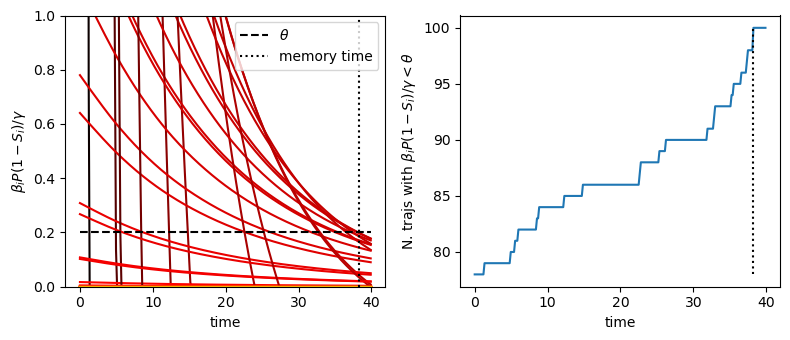

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8, 3.5))

cmap = colormaps.get_cmap('hot_r')
cmap_norm = plt.Normalize(vmin=min(np.log10(taus)), vmax=max(np.log10(taus)))

ax1.set_ylim(0,1)
ax1.set_ylabel(r'$\beta_i P (1 - S_i) / \gamma$')
ax1.set_xlabel('time')
for i, gr in enumerate(growth_rates.T):
    color = cmap(cmap_norm(np.log10(taus[i])))
    ax1.plot(times, gr/pars.gamma, c=color)
ax1.plot(times, theta * np.ones(len(times)), ls='--', c='k', label=r'$\theta$')
ax1.plot([time_memory, time_memory], [0, 1], ls=':', c='k', label='memory time')
ax1.legend()

ax2.set_ylabel(r'N. trajs with $\beta_i P (1 - S_i) / \gamma < \theta$')
ax2.set_xlabel('time')
ax2.plot(times, gr_small_than_th)
ax2.plot([time_memory, time_memory], [min(gr_small_than_th), pars.n], ls=':', c='k')

plt.tight_layout()

## Detecting the maximum of abundance-affinity plot in an ensemble

The most consistent way of doing it seems to use the ensamble of trajectories of the derivative and check when the cross the zero.

I tried also by using the scatter plot of all the points tau-T generated in the ensamble, but this cloud seems to bias the position of the maximum and I can find fake maximums also in case of alpha0 = 0.

In [21]:
R = 200 # Number of realizations
pars = ut.TT_params([1], alpha0=1e-5)

# Approximated position of the average maximum
av_max_tau = ut.av_max_lognorm(logmean, logstd, n_samples)

taus_mat, Tfreqs_mat = [], []
for _ in range(R):
    taus = ut.sample_taus_lognorm(logmean, logstd, n_samples)
    taus_mat.append(taus)
    pars.set_taus(taus)
    times, T_trajs, P_trajs, S_trajs = ut.run_setting(pars, t_steps, dt, traj_steps=traj_steps, stop_cond=stop_cond)
    Tfreqs_mat.append(T_trajs[-1] / T_trajs[-1].sum())

In [22]:
def find_max(taus_mat, Tfreqs_mat, no_max_perc=0.9, verbose=False):

    # Moving to the log transformed variables, sorting them and taking the derivative
    logtaus, logTfreq = np.log10(taus_mat), np.log10(Tfreqs_mat)
    tau_sort_i = np.argsort(logtaus, axis=1)
    logtaus = np.take_along_axis(logtaus, tau_sort_i, axis=1)
    logTfreq = np.take_along_axis(logTfreq, tau_sort_i, axis=1)
    ders = (logTfreq[:,1:] - logTfreq[:,:-1]) / (logtaus[:,1:] - logtaus[:,:-1])
    mid_logtaus = (logtaus[:,1:] + logtaus[:,:-1]) / 2.0

    # Iterating over the trajectories to look for the stat point
    x_maxs, slopes = [], []
    for r in range(R):
        # Function already increasing at the end -> always increasing
        if ders[r][-1] > 0:
            x_maxs.append(float('nan'))
            slopes.append(1)
        else:
            y0, x0 = ders[r][-1], mid_logtaus[r][-1]
            # Searching for the max from the last point
            for i in range(1,len(ders[r])):
                y1, x1 = ders[r][-i-1], mid_logtaus[r][-i-1]
                # Change of sign found -> stat point
                if y0*y1 < 0:
                    # Linear interpolation to get the zero
                    x_maxs.append(x1 + y1*(x0-x1)/(y1-y0))
                    slopes.append(0)
                    break
            # I no max are found and the final derivative is positive, the function is decreasing
            if len(x_maxs) == r: 
                x_maxs.append(float('nan'))
                slopes.append(-1)

    # Aggregating the info 
    x_maxs = np.array(x_maxs)
    n_no_max = np.isnan(x_maxs).sum()
    if n_no_max/R > no_max_perc:
        if verbose: print('Most of trajectories do not display maximums')
        return float('nan'), float('nan'), np.mean(slopes)
    x_max = np.mean(x_maxs[~np.isnan(x_maxs)])
    y_maxs = []
    for r in range(R):
        if np.isnan(x_maxs[r]): continue
        y_maxs.append(np.interp(x_max, logtaus[r], logTfreq[r]))
        print(y_maxs[-1], x_maxs[r])
    y_max = np.mean(y_maxs)
    return x_max, y_max, np.mean(slopes)

x_max, y_max, slope = find_max(taus_mat, Tfreqs_mat, no_max_perc=0.9, verbose=True)
print(x_max, y_max)

-0.28186906256613575 0.9762019946352198
-0.4402186595994232 1.0028918430140814
-0.6453159590311893 0.9973017081797345
-0.6824354968893781 1.0493479560292227
-0.5149117521804752 1.037694046874873
-0.39885077504575184 0.9895548491222721
-0.41009397537565984 0.9735067482415037
-0.21661147242640308 1.0093528256493234
-0.6117100665723927 1.0113283401426156
-0.4733867102282309 0.981956106915693
-0.6566054643002631 0.991336980321748
-0.7289643121852837 1.0070347637078514
-0.4570342616481378 1.0253959872319456
-0.5065737899007635 0.9827045107385491
-0.7042298025762 0.9974076356186812
-0.4006869257740384 0.9761061460246789
-0.4090741028543589 0.9773661891463704
-0.5350416862310713 0.9677247323222461
-0.5788137260905656 0.9824880491720631
-0.60276771261044 0.9995278088653005
-0.4906928870318767 1.0835477781890575
-0.677405599642698 1.0015821365011768
-0.46163502094766046 1.0898529059187632
-0.37966387571965965 1.0366083019083299
-0.6140815398454821 0.9933918405278933
-0.7004715436462241 1.001157

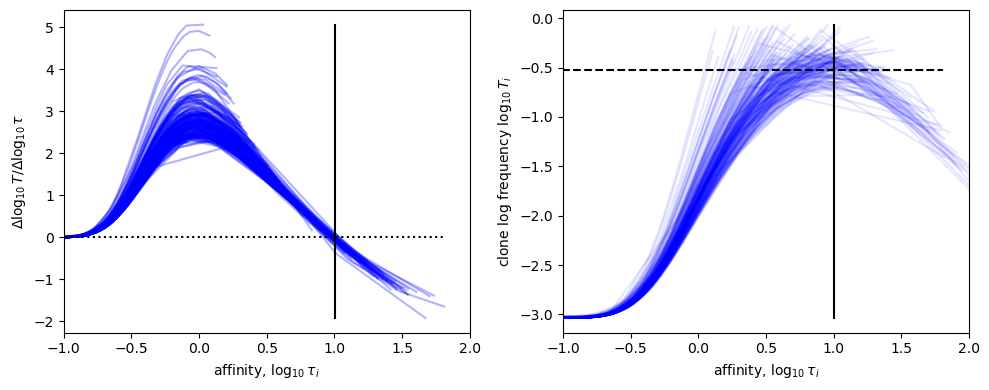

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
xlim = (-1, 2)

ax1.set_ylabel(r'$\Delta \log_{10} T / \Delta \log_{10} \tau$')
ax1.set_xlabel(r'affinity, $\log_{10}\tau_i$')
ax1.set_xlim(xlim)
logtaus, logTfreq = np.log10(taus_mat), np.log10(Tfreqs_mat)
tau_sort_i = np.argsort(logtaus, axis=1)
logtaus = np.take_along_axis(logtaus, tau_sort_i, axis=1)
logTfreq = np.take_along_axis(logTfreq, tau_sort_i, axis=1)
ders = (logTfreq[:,1:] - logTfreq[:,:-1]) / (logtaus[:,1:] - logtaus[:,:-1])
mid_logtaus = (logtaus[:,1:] + logtaus[:,:-1]) / 2.0
for r in range(R):
    ax1.plot(mid_logtaus[r], ders[r], c='b', alpha=0.3)
xs = np.linspace(np.min(mid_logtaus), np.max(mid_logtaus), 2)
ax1.plot(xs, np.zeros(len(xs)), c='k', ls=':')
ys = np.linspace(np.min(ders), np.max(ders), 2)
ax1.plot([x_max, x_max], ys, c='k')

ax2.set_ylabel(r'clone log frequency $\log_{10} T_i$')
ax2.set_xlabel(r'affinity, $\log_{10}\tau_i$')
ax2.set_xlim(xlim)
for r in range(R):
    ax2.plot(logtaus[r], logTfreq[r], c='b', alpha=0.1)
ys = np.linspace(np.min(logTfreq), np.max(logTfreq), 2)
ax2.plot([x_max, x_max], ys, c='k')
ax2.plot(xs, np.ones(len(xs))*y_max, c='k', ls='--')

#plt.xlim(0,2)
plt.tight_layout()